# **Survival Time Prediction and Exploratory Analysis of Battle Royale Player Data**

## **PROJECT OVERVIEW**

The Battle Royale dataset captures detailed information about players across various servers, tiers, and roles, including metrics such as Kill-Death ratio (KD), experience points, level, achievements, mode, and activity status. However, the raw dataset contains missing values, inconsistent entries, and lacks structured survival time labels.

The goal of this project is to **clean and preprocess the dataset**, then apply a **hybrid technique (rule-based + machine learning)** to predict each player's survival duration category. In addition, the project performs **exploratory data analysis (EDA)** to uncover patterns in player performance, tier behavior, and region-based distributions. Through high-quality and interactive visualizations, we gain insights into the factors affecting survival and player trends. The findings can inform game balancing, matchmaking systems, and player retention strategies.

---

## **OBJECTIVES**

### ✅ **Data Cleaning & Preprocessing**

- Detect and remove **invalid entries** (e.g., players with low experience but high achievements).
- Handle missing values using appropriate techniques (e.g., median imputation).
- Derive **survival labels** based on rules: `<10min`, `<20min`, `<30min`, or `Uncertain`.
- Normalize and encode relevant features for machine learning compatibility.

---

### ✅ **Machine Learning Prediction**

- Train a **Random Forest Classifier** using rule-labeled survival durations.
- Use reliable features (KD, level, achievements, mode, tier, etc.) for prediction.
- Evaluate model performance with precision, recall, F1-score, and accuracy.
- Save model pipeline for reproducibility and deployment.

---

### ✅ **Exploratory Data Analysis (EDA)**

- Visualize **average KD and survival time per server** to understand server behavior.
- Generate insightful plots:
  - **KD Ratio vs Tier** using violin/box plots.
  - **Player count and achievements per region** using interactive scatter/bubble plots.
  - **Density of KD values** around the average using regression & KDE plots.
- Analyze patterns across **modes (Solo, Duo, Squad)** and **activity types (Returner, Dominator, etc.)**.

---

### ✅ **Advanced Visualizations**

- Use **Seaborn**, **Matplotlib**, and **Plotly Express** for professional-grade visual appeal.
- Apply:
  - **Premium color palettes** (deep, pastel, or custom themes).
  - **Annotated plots and titles** for interpretability.
  - **Interactive visualizations** for deeper analysis.
- Improve layout with grid-based subplots, tight axis limits, and clean legends.

---

## **STATISTICAL & BUSINESS INSIGHTS**

- Reveal how **Tier level impacts KD and survival**.
- Identify player categories most likely to survive longer or perform better.
- Discover underperforming regions or player clusters needing intervention.
- Flag **suspicious/fake profiles** based on inconsistencies between achievements, experience, and survival.

---

## **BUSINESS RECOMMENDATIONS**

- Tailor **game difficulty and rewards** for high-risk players (<10min survival).
- Implement **region-aware matchmaking** based on player density and server performance.
- Promote fair competition by balancing **Tier-based progression**.
- Support player engagement by adjusting **goals/achievements** based on survival prediction.

---

## **DELIVERABLES**

- ✅ Cleaned and preprocessed dataset
- ✅ Rule-labeled and ML-predicted survival outcomes
- ✅ Trained machine learning model (Random Forest)
- ✅ Interactive and professional EDA visualizations
- ✅ A complete Jupyter Notebook with code, visuals, and insights


### **1) Importing relavant libraries**

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


### **2) Loading the Dataset & Handling missing values**

In [32]:
df = pd.read_excel('Data/test_Battle_Royale.csv.xlsx')

categorical_cols = ['Role', 'Tier', 'ActivityStatus']
numerical_cols = ['Experience', 'Level', 'Achievements', 'KD']

df[categorical_cols] = df[categorical_cols].fillna('Unknown')
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())


In [29]:
print(df.head())

      Server  Mode         PlayerName     Role  Experience  Level     Tier  \
0       Asia  Solo      IronSlayer866      IGL         3.6   51.0     Gold   
1       Asia  Solo   InfernoRanger694  Unknown         3.6   43.0    Crown   
2  Australia   Duo     VenomOutlaw708   Sniper         3.6   72.0  Unknown   
3    America  Solo     VenomReaper128  Unknown         7.1   67.0     Gold   
4       Asia  Solo  DeadlyCommando434      IGL         6.9   81.0      Ace   

  ActivityStatus  Achievements     KD  FalseEntry  LegendPlayer  \
0        Unknown        5540.0  10.55       False         False   
1         Casual        6416.0  12.10       False         False   
2        Unknown        8288.0   6.48       False         False   
3       Returner        7200.0   7.56       False          True   
4        Unknown        6812.0   2.47       False         False   

   UltimateLegend  
0           False  
1           False  
2           False  
3            True  
4           False  


### 3) **Checking for duplicates**

In [33]:
print(f"Duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)   

Duplicate rows: 0


### **4) Rejecting invalid Entries**

In [30]:
condition1 = (df['ActivityStatus'] == 'Returner') & (df['Tier'].isin(['Legend', 'Dominator', 'Conqueror']))

condition2 = (df['Experience'] <= 3) & (df['Achievements'] > 5000)

df['FalseEntry'] = (condition1 | condition2)


In [13]:
valid_df = df[~df['FalseEntry']].copy()

### **5) Survival Time Prediction**

In [14]:
def predict_survival(row):
    if (row['KD'] <= 5) and (row['ActivityStatus'] in ['Returner', 'Casual']) and (row['Tier'] in ['Gold', 'Platinum', 'Diamond']):
        return '<10min'
    elif (3 < row['KD'] <= 10) and (row['Tier'] in ['Diamond', 'Crown']):
        return '<20min'
    elif (8 <= row['KD'] <= 15) and (row['ActivityStatus'] in ['Regular', 'Casual']) and (row['Tier'] in ['Ace', 'Dominator', 'Legend', 'Conqueror']):
        return '<30min'
    else:
        return 'Uncertain'

valid_df['SurvivalTime'] = valid_df.apply(predict_survival, axis=1)


### **6) Invalid Enteries**

In [15]:
false_entries = df[df['FalseEntry']]
false_entries.head()

,Server,Mode,PlayerName,Role,Experience,Level,Tier,ActivityStatus,Achievements,KD,FalseEntry
13,Asia,Solo,RogueDestroyer553,Unknown,3.6,80.0,Dominator,Returner,6812.0,8.33,True
15,America,Squad,DeadlyNinja898,Unknown,2.5,63.0,Gold,Regular,6874.0,8.17,True
18,Europe,Solo,FatalHunter723,IGL,1.1,54.0,Ace,Regular,7910.0,8.17,True
20,America,Duo,DarkCommando961,Assaulter,2.6,67.0,Platinum,Regular,6812.0,5.16,True
26,America,Squad,FatalBerserk727,Assaulter,1.7,77.0,Ace,Regular,8037.0,8.17,True


### **7) Legend & Ultimate legend players**

In [16]:
df['LegendPlayer'] = (df['Experience'] >= 6) & (df['Achievements'] >= 7000)
df['UltimateLegend'] = df['LegendPlayer'] & (df['ActivityStatus'] == 'Returner')

### **8) Basic Visualization**

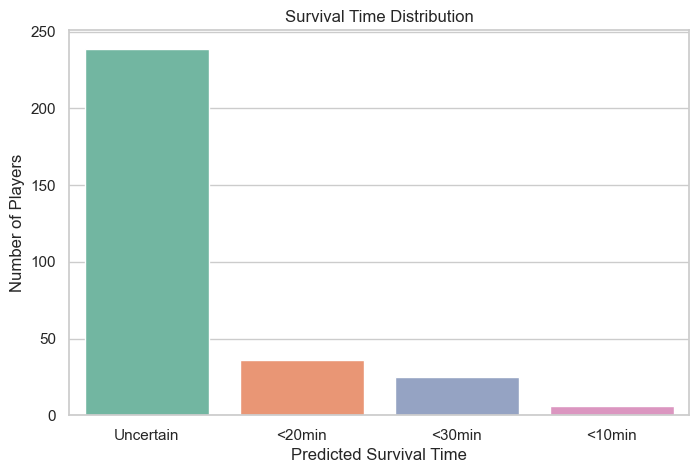

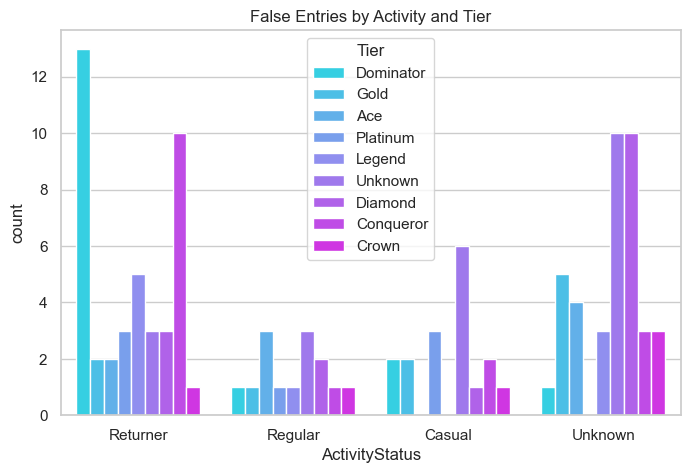

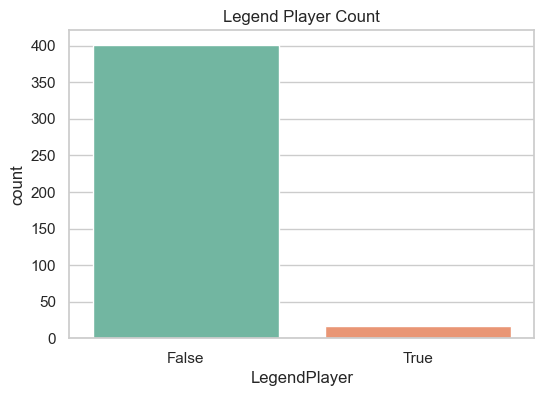

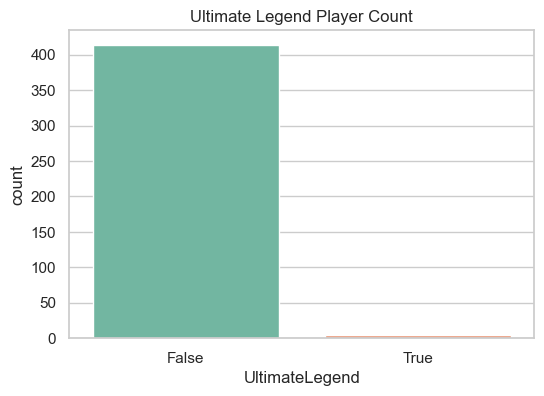

In [17]:
# Graph for Survival Time distribution
plt.figure(figsize=(8,5))
sns.countplot(data=valid_df, x='SurvivalTime', hue='SurvivalTime', palette='Set2', legend=False)
plt.title("Survival Time Distribution")
plt.xlabel("Predicted Survival Time")
plt.ylabel("Number of Players")
plt.show()

# Graph: FALSE Entries 
plt.figure(figsize=(8,5))
sns.countplot(data=df[df['FalseEntry']], x='ActivityStatus', hue='Tier', palette='cool')
plt.title("False Entries by Activity and Tier")
plt.show()

# Graph: Legend Players
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='LegendPlayer', hue='LegendPlayer', palette='Set2', legend=False)
plt.title("Legend Player Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='UltimateLegend', hue='UltimateLegend', palette='Set2', legend=False)
plt.title("Ultimate Legend Player Count")
plt.show()


### **Distribution of Players by Survival Time**

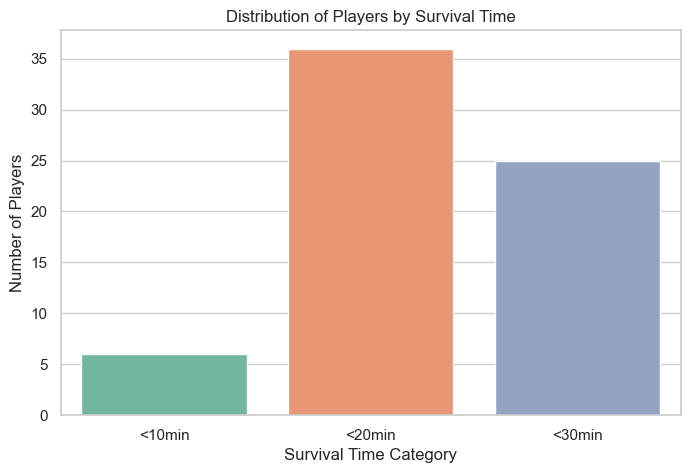

In [19]:
#Counting how many players are in <10min, <20min, <30min
survival_counts = valid_df['SurvivalTime'].value_counts().reindex(['<10min', '<20min', '<30min'], fill_value=0)
plt.figure(figsize=(8,5))
sns.barplot(x=survival_counts.index, y=survival_counts.values, palette='Set2')
plt.title("Distribution of Players by Survival Time")
plt.xlabel("Survival Time Category")
plt.ylabel("Number of Players")
plt.show()


Accuracy: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

      <10min       1.00      0.50      0.67         2
      <20min       0.89      1.00      0.94         8
      <30min       1.00      1.00      1.00         4

    accuracy                           0.93        14
   macro avg       0.96      0.83      0.87        14
weighted avg       0.94      0.93      0.92        14



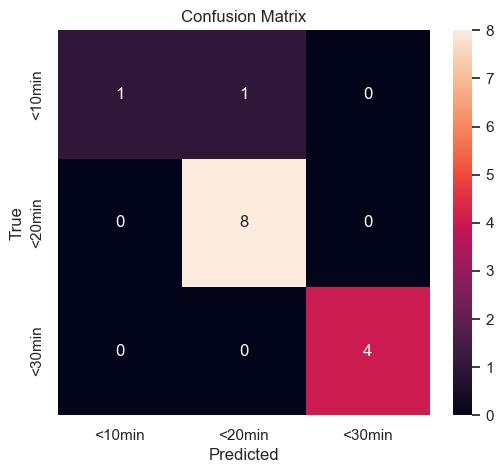

In [20]:
#Filter out 'Uncertain' classes
train_df = valid_df[valid_df['SurvivalTime'] != 'Uncertain'].copy()

#Label encode target
le = LabelEncoder()
train_df['SurvivalTimeLabel'] = le.fit_transform(train_df['SurvivalTime'])  # <10min = 0, <20min = 1, <30min = 2

#Encoding categorical variables
encoded_df = pd.get_dummies(train_df[['Server', 'Mode', 'Role', 'Tier', 'ActivityStatus']], drop_first=True)

X = pd.concat([train_df[['Experience', 'Level', 'Achievements', 'KD']], encoded_df], axis=1)
y = train_df['SurvivalTimeLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Predictions
y_pred = clf.predict(X_test)

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

#Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### **KD Distribution**

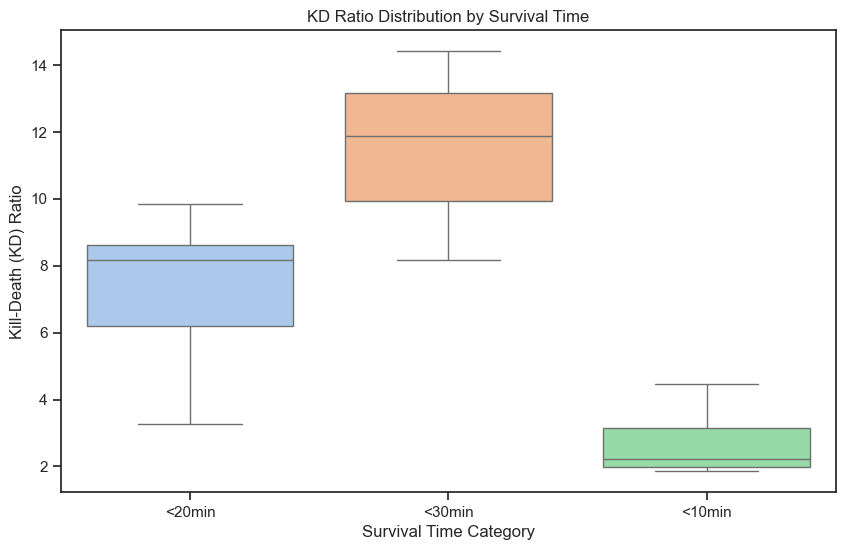

In [23]:
# Visualization of KD vs Survival Time
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='SurvivalTime', y='KD', palette='pastel')
plt.title("KD Ratio Distribution by Survival Time")
plt.xlabel("Survival Time Category")
plt.ylabel("Kill-Death (KD) Ratio")
plt.show()


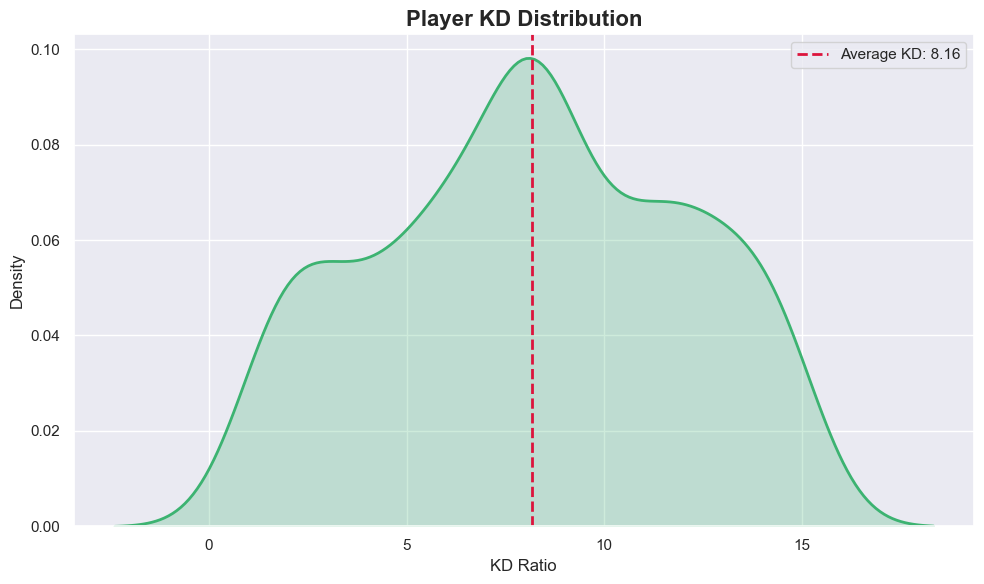

In [21]:
# Calculate Avg KD
avg_kd = df['KD'].mean()

plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
sns.kdeplot(df['KD'], fill=True, color='mediumseagreen', linewidth=2)
plt.axvline(avg_kd, color='crimson', linestyle='--', linewidth=2, label=f'Average KD: {avg_kd:.2f}')
plt.title("Player KD Distribution", fontsize=16, weight='bold')
plt.xlabel("KD Ratio")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


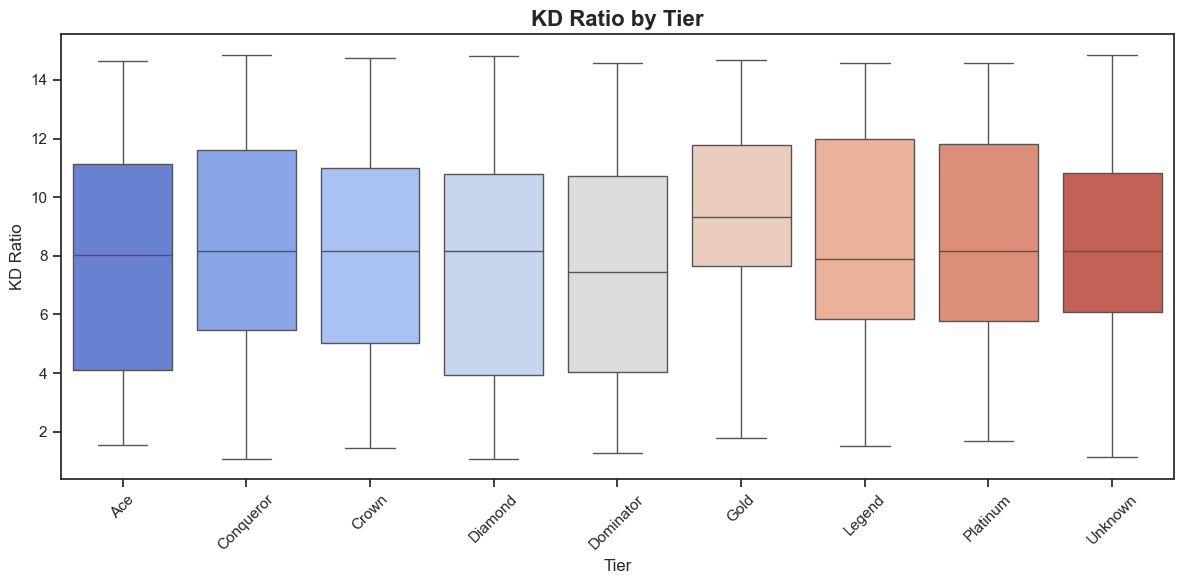

In [22]:
tier_order = sorted(df['Tier'].unique())
plt.figure(figsize=(12, 6))
sns.set(style="ticks")
sns.boxplot(data=df, x='Tier', y='KD', palette='coolwarm', order=tier_order)
plt.title("KD Ratio by Tier", fontsize=16, weight='bold')
plt.xlabel("Tier")
plt.ylabel("KD Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Basic Visualization by Server/Region**

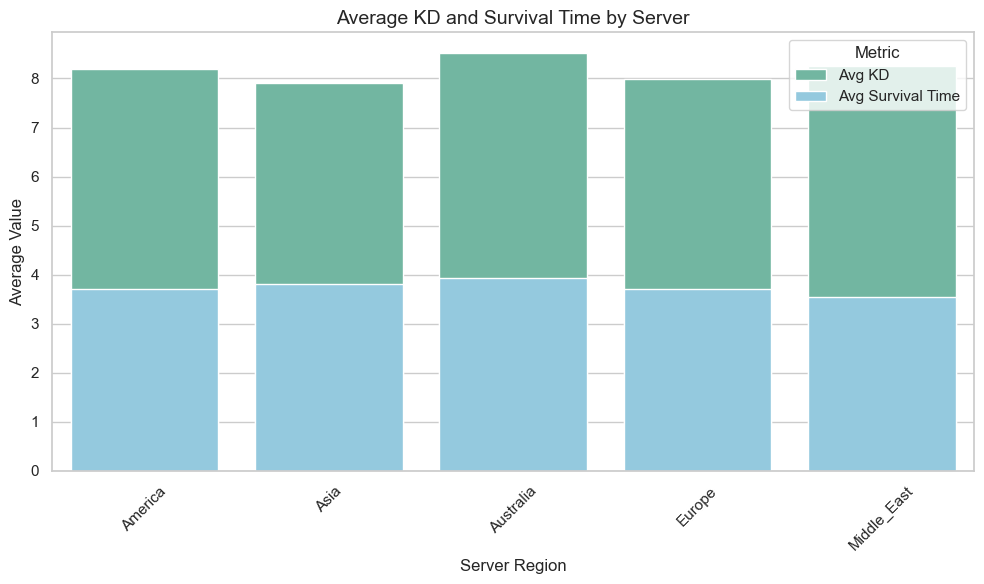

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")
df_kd = df[['Server', 'KD', 'Experience']].dropna()
server_stats = df_kd.groupby('Server').mean().reset_index()

plt.figure(figsize=(10, 6))
bar1 = sns.barplot(data=server_stats, x='Server', y='KD', label='Avg KD')
bar2 = sns.barplot(data=server_stats, x='Server', y='Experience', color='skyblue', label='Avg Survival Time')
plt.title('Average KD and Survival Time by Server', fontsize=14)
plt.ylabel('Average Value')
plt.xlabel('Server Region')
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

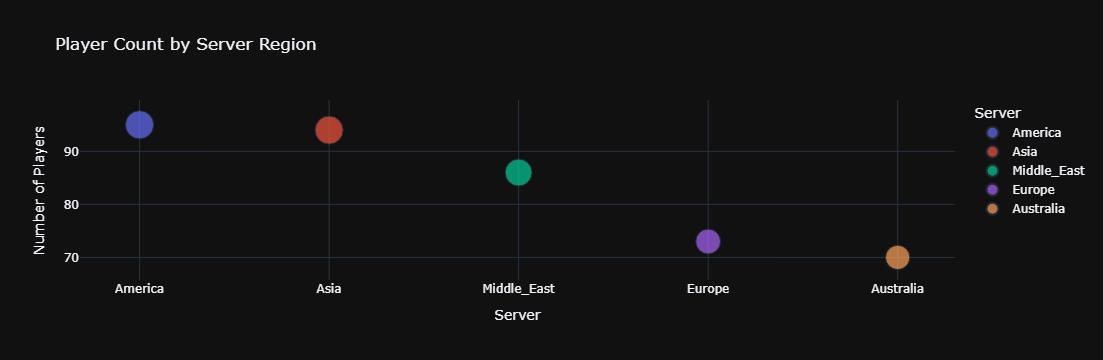

In [26]:
import plotly.express as px

player_counts = df['Server'].value_counts().reset_index()
player_counts.columns = ['Server', 'PlayerCount']

fig = px.scatter(player_counts, x='Server', y='PlayerCount', color='Server',
                 size='PlayerCount', title='Player Count by Server Region',
                 labels={'PlayerCount': 'Number of Players'},
                 hover_name='Server', template='plotly_dark')
fig.show()

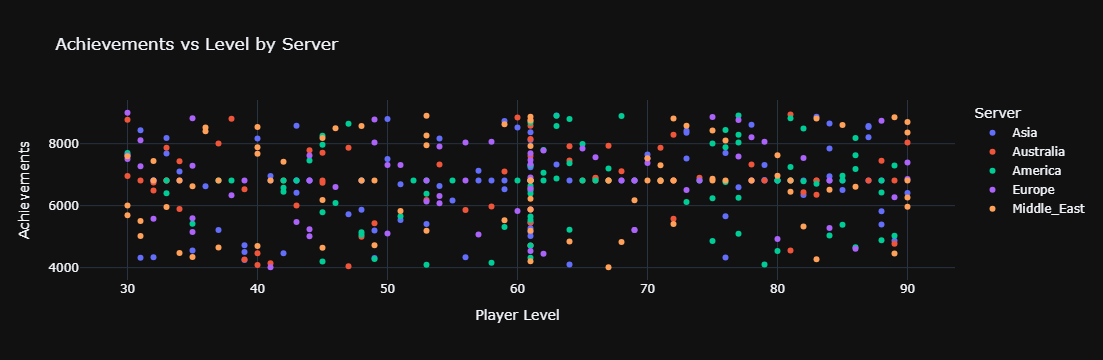

In [27]:
df_clean = df[['Server', 'Achievements', 'Level']].dropna()

fig = px.scatter(df_clean, x='Level', y='Achievements', color='Server',
                 title='Achievements vs Level by Server',
                 labels={'Level': 'Player Level', 'Achievements': 'Achievements'},
                 hover_data=['Server'], template='plotly_dark')
fig.show()

# **Thank You**